# Estimating prediction intervals of time series forecast with EnbPI

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/add-ts-notebooks/notebooks/regression/ts-changepoint.ipynb)

Note: in this tutorial, we use the following terms employed in the scientific literature:
- `alpha` is equivalent to `1 - confidence_level`. It can be seen as a *risk level*
- *calibrate* and *calibration*, are equivalent to *conformalize* and *conformalization*. 

This example uses `mapie.time_series_regression.TimeSeriesRegressor` to estimate
prediction intervals associated with time series forecast. It follows Xu \& Xie (2021).
We use here the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.
A Random Forest model is already fitted on data. The hyper-parameters are
optimized with a `sklearn.model_selection.RandomizedSearchCV` using a
sequential `sklearn.model_selection.TimeSeriesSplit` cross validation,
in which the training set is prior to the validation set.
The best model is then feeded into
`mapie.time_series_regression.TimeSeriesRegressor` to estimate the
associated prediction intervals. We compare four approaches: with or without
``update`` called at every step.

In [1]:
install_mapie = False
if install_mapie:
    !pip install mapie

In [2]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics.regression import regression_coverage_score, regression_mean_width_score, coverage_width_based
from mapie.subsample import BlockBootstrap
from mapie.regression import TimeSeriesRegressor
from mapie.conformity_scores.regression import BaseRegressionScore
from mapie.conformity_scores.interface import BaseConformityScore

%reload_ext autoreload
%autoreload 2
warnings.simplefilter("ignore")




## 1. Load input data and feature engineering

In [3]:
url_file = "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/examples/data/demand_temperature.csv"
demand_df = pd.read_csv(
    url_file, parse_dates=True, index_col=0
)

demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)



## 2. Train/validation/test split

In [4]:
num_test_steps = 24 * 7
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"] 
features += [f"Lag_{hour}" for hour in range(1, n_lags)]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, "Demand"]
X_test = demand_test.loc[:, features]
y_test = demand_test["Demand"]

Text(0, 0.5, 'Hourly demand (GW)')

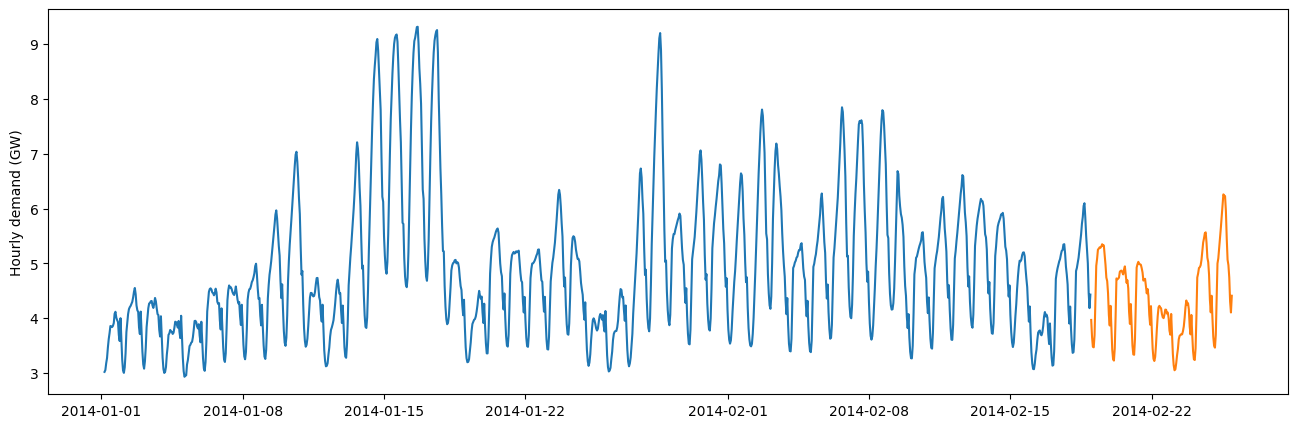

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(y_train)
plt.plot(y_test)
plt.ylabel("Hourly demand (GW)")

## 3. Optimize the base estimator

In [6]:
model_params_fit_not_done = False
if model_params_fit_not_done:
    # CV parameter search
    n_iter = 100
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)
    random_state = 59
    rf_model = RandomForestRegressor(random_state=random_state)
    rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 100)}
    cv_obj = RandomizedSearchCV(
        rf_model,
        param_distributions=rf_params,
        n_iter=n_iter,
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        random_state=random_state,
        verbose=0,
        n_jobs=-1,
    )
    cv_obj.fit(X_train, y_train)
    model = cv_obj.best_estimator_
else:
    # Model: Random Forest previously optimized with a cross-validation
    model = RandomForestRegressor(
        max_depth=10, n_estimators=50, random_state=59)

## 4. Estimate prediction intervals on the test set

In [7]:
alpha = 0.05
gap = 1
cv_mapiets = BlockBootstrap(
    n_resamplings=100, length=48, overlapping=True, random_state=59
)
mapie_enbpi = TimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)
mapie_aci = TimeSeriesRegressor(
    model, method="aci", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

### Without update

In [ ]:
print("EnbPI, with no update, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_enbpi_no_update, y_pis_enbpi_no_update = mapie_enbpi.predict(
    X_test, confidence_level=1-alpha, ensemble=True, optimize_beta=True
)
coverage_enbpi_no_update = regression_coverage_score(y_test, y_pis_enbpi_no_update)[0]
width_enbpi_no_update = regression_mean_width_score(y_pis_enbpi_no_update)[0]
cwc_enbpi_no_update = coverage_width_based(
    y_test, y_pis_enbpi_no_update[:, 0, 0], y_pis_enbpi_no_update[:, 1, 0], eta = 10, confidence_level = 0.95
)


EnbPI, with no partial_fit, width optimization


In [ ]:
print("ACI, with no update")
mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci_no_update, y_pis_aci_no_update = mapie_aci.predict(
    X_test, confidence_level=1-alpha, ensemble=True, optimize_beta=True
)
coverage_aci_no_update = regression_coverage_score(y_test, y_pis_aci_no_update)[0]
width_aci_no_update = regression_mean_width_score(y_pis_aci_no_update)[0]
cwc_aci_no_update = coverage_width_based(
    y_test, y_pis_aci_no_update[:, 0, 0], y_pis_aci_no_update[:, 1, 0], eta = 10, confidence_level = 0.95
)

ACI, with no partial_fit


### With update

In [ ]:
print("EnbPI with update, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_enbpi_update = np.zeros(y_pred_enbpi_no_update.shape)
y_pis_enbpi_update = np.zeros(y_pis_enbpi_no_update.shape)
y_pred_enbpi_update[:gap], y_pis_enbpi_update[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], confidence_level=1-alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(X_test), gap):
    mapie_enbpi.update(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_enbpi_update[step:step + gap],
        y_pis_enbpi_update[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        confidence_level=1-alpha,
        ensemble=True,
        optimize_beta=True
    )
coverage_enbpi_update = regression_coverage_score(y_test, y_pis_enbpi_update)[0]
width_enbpi_update = regression_mean_width_score(y_pis_enbpi_update)[0]
cwc_enbpi_update = coverage_width_based(
    y_test, y_pis_enbpi_update[:, 0, 0], y_pis_enbpi_update[:, 1, 0], eta = 10, confidence_level = 0.95
)

EnbPI with partial_fit, width optimization


In [ ]:
print("ACI with adapt_conformal_inference")
mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci_update = np.zeros(y_pred_aci_no_update.shape)
y_pis_aci_update = np.zeros(y_pis_aci_no_update.shape)
y_pred_aci_update[:gap], y_pis_aci_update[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], confidence_level=1-alpha, ensemble=True, optimize_beta=True
)

for step in range(gap, len(X_test), gap):
    mapie_aci.update(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma = 0.05
    )
    (
        y_pred_aci_update[step:step + gap],
        y_pis_aci_update[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        confidence_level=1-alpha,
        ensemble=True,
        optimize_beta=True
    )
    
coverage_aci_update = regression_coverage_score(y_test, y_pis_aci_update)[0]
width_aci_update = regression_mean_width_score(y_pis_aci_update)[0]
cwc_aci_update = coverage_width_based(
    y_test, y_pis_aci_update[:, 0, 0], y_pis_aci_update[:, 1, 0], eta = 0.01, confidence_level = 0.95
)

ACI with adapt_conformal_inference


In [ ]:
print('cwc aci : ' + str(cwc_aci_update) + ' cwc enbpi : ' + str(cwc_enbpi_update))

cwc aci : 0.8858773125796118 cwc enbpi : 0.8065468819715975


## V. Plot estimated prediction intervals on test set

In [ ]:
y_enbpi_preds = [y_pred_enbpi_no_update, y_pred_enbpi_update]
y_enbpi_pis = [y_pis_enbpi_no_update, y_pis_enbpi_update]
coverages_enbpi = [coverage_enbpi_no_update, coverage_enbpi_update]
widths_enbpi = [width_enbpi_no_update, width_enbpi_update]

In [ ]:
y_aci_preds = [y_pred_aci_no_update, y_pred_aci_update]
y_aci_pis = [y_pis_aci_no_update, y_pis_aci_update]
coverages_aci = [coverage_aci_no_update, coverage_aci_update]
widths_aci = [width_aci_no_update, width_aci_update]

In [15]:
def plot_forecast(method, y_train, y_test, y_preds, y_pis, coverages, widths, plot_coverage=True):
    fig, axs = plt.subplots(
        nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
    )
    for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
        ax.set_ylabel("Hourly demand (GW)")
        ax.plot(y_train[int(-len(y_test)/2):], lw=2, label="Training data", c="C0")
        ax.plot(y_test, lw=2, label="Test data", c="C1")

        ax.plot(
            y_test.index, y_preds[i], lw=2, c="C2", label="Predictions"
        )
        ax.fill_between(
            y_test.index,
            y_pis[i][:, 0, 0],
            y_pis[i][:, 1, 0],
            color="C2",
            alpha=0.2,
            label="Prediction intervals",
        )
        title = f"{method}, {w} update of residuals. "
        if plot_coverage:
            title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
        ax.set_title(title)
        ax.legend()
    fig.tight_layout()
    plt.show()

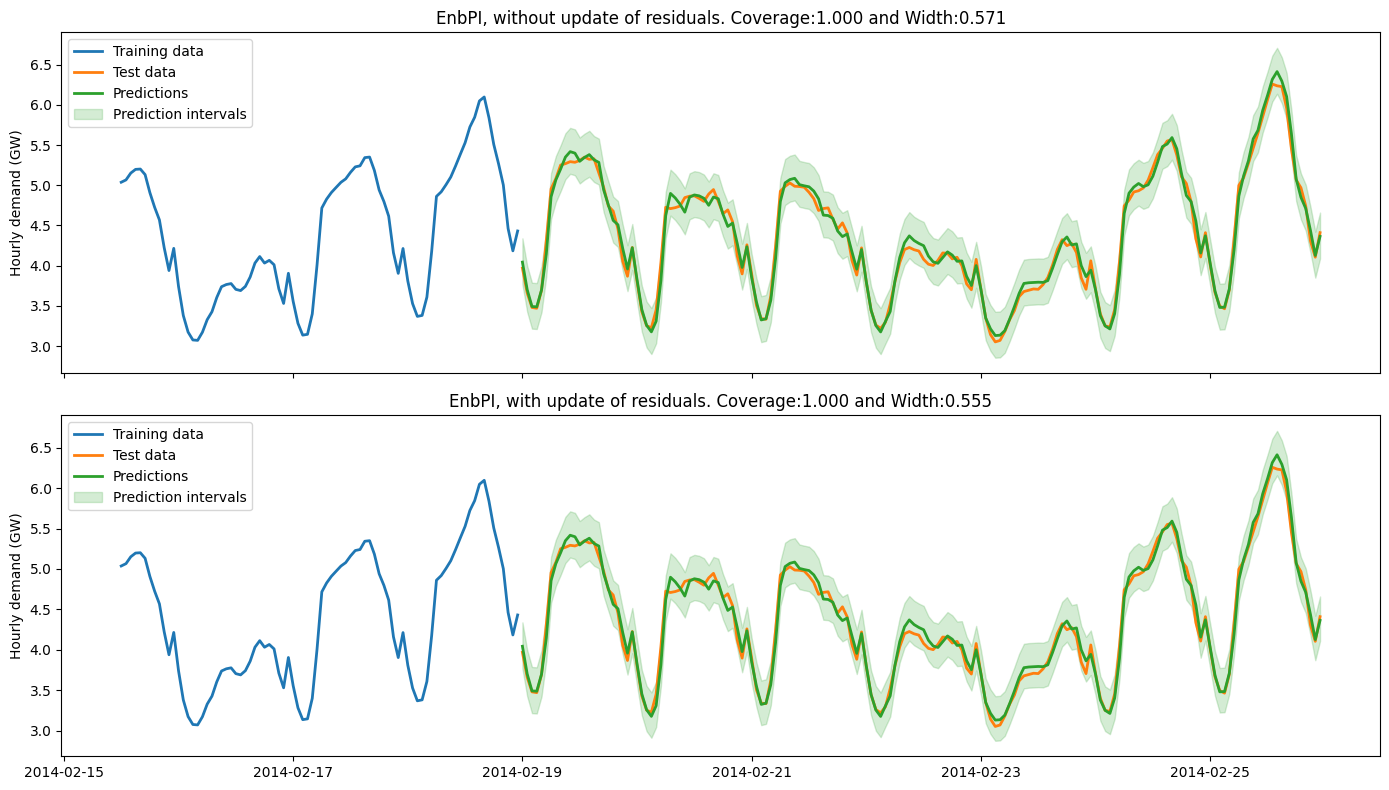

In [16]:
plot_forecast("EnbPI", y_train, y_test, y_enbpi_preds, y_enbpi_pis, coverages_enbpi, widths_enbpi)

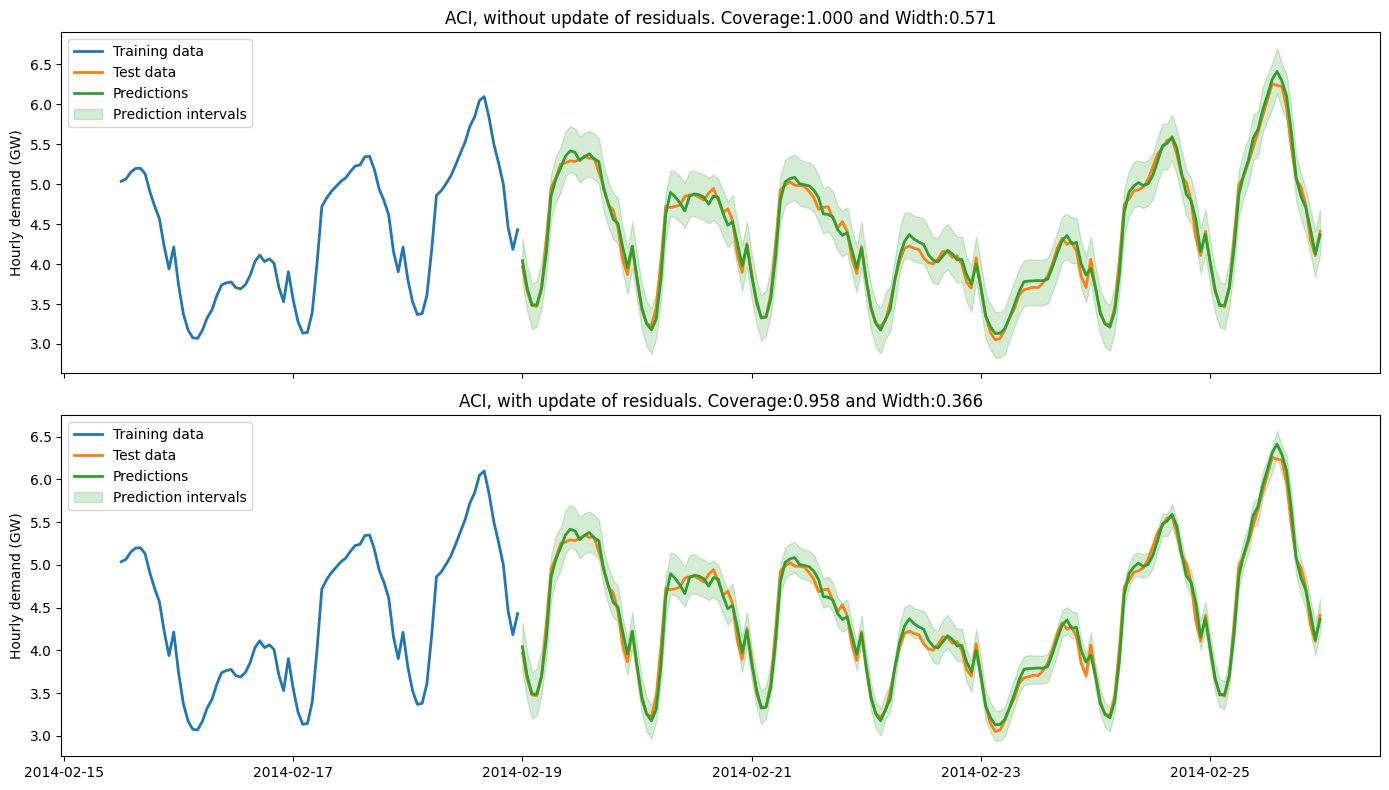

In [17]:
plot_forecast("ACI", y_train, y_test, y_aci_preds, y_aci_pis, coverages_aci, widths_aci)

## VI. Forecast on test dataset with change point

We will now see how MAPIE adapts its prediction intervals when a brutal changepoint arises in the test set. To simulate this, we will artificially decrease the electricity demand by 2 GW in the test set, aiming at simulating an effect, such as blackout or lockdown due to a pandemic, that was not taken into account by the model during its training. 

### Corrupt the dataset

In [18]:
demand_df_corrupted = demand_df.copy()
demand_df_corrupted.Demand.iloc[-int(num_test_steps/2):] -= 2

In [19]:
n_lags = 5
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)
demand_train_corrupted = demand_df_corrupted.iloc[:-num_test_steps, :].copy()
demand_test_corrupted = demand_df_corrupted.iloc[-num_test_steps:, :].copy()

X_train = demand_train_corrupted.loc[
    ~np.any(demand_train_corrupted[features].isnull(), axis=1), features
]
y_train = demand_train_corrupted.loc[X_train.index, "Demand"]
X_test = demand_test_corrupted.loc[:, features]
y_test = demand_test_corrupted["Demand"]

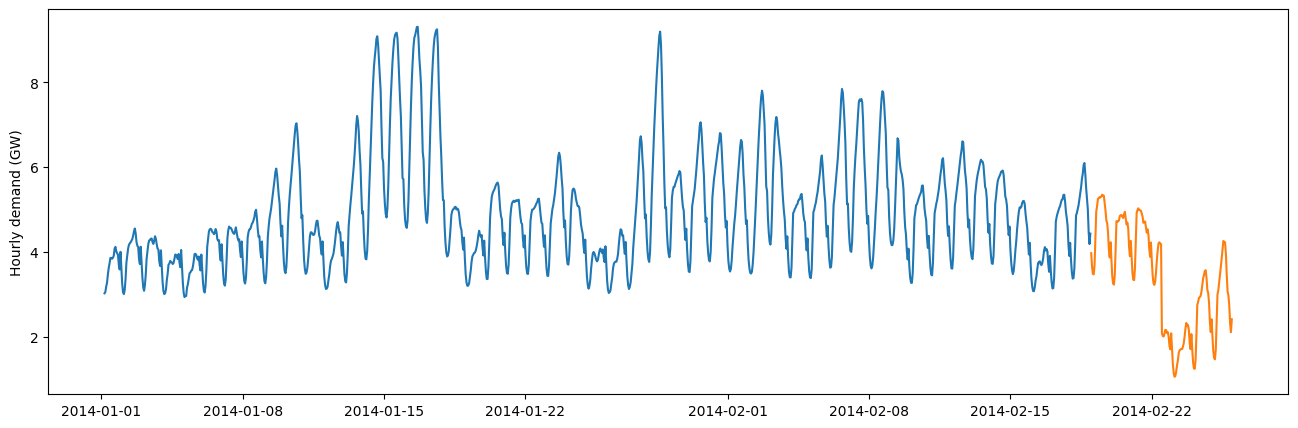

In [20]:
plt.figure(figsize=(16, 5))
plt.ylabel("Hourly demand (GW)")
plt.plot(y_train)
plt.plot(y_test)

### Prediction intervals without update

In [ ]:
print("EnbPI, with no update, width optimization")
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)
y_pred_enbpi_no_update, y_pis_enbpi_no_update = mapie_enbpi.predict(
    X_test, confidence_level=1-alpha, ensemble=True, optimize_beta=True, allow_infinite_bounds=True
)

y_pis_enbpi_no_update = y_pis_enbpi_no_update.copy()

y_pis_enbpi_no_update = np.clip(y_pis_enbpi_no_update, 1, 10)

if np.any(y_pis_enbpi_no_update != y_pis_enbpi_no_update):
    print("An approximation was used. All values have been clipped to the range [1, 10].")

coverage_enbpi_no_update = regression_coverage_score(y_test, y_pis_enbpi_no_update)[0]
width_enbpi_no_update = regression_mean_width_score(y_pis_enbpi_no_update)[0]
cwc_enbpi_no_update = coverage_width_based(
    y_test, y_pis_enbpi_no_update[:, 0, 0], y_pis_enbpi_no_update[:, 1, 0], eta = 10, confidence_level = 0.95
)

EnbPI, with no partial_fit, width optimization


In [ ]:
print("ACI, with no update")
mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci_no_update = np.zeros(y_pred_enbpi_no_update.shape)
y_pis_aci_no_update = np.zeros(y_pis_enbpi_no_update.shape)
y_pred_aci_no_update[:gap], y_pis_aci_no_update[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], confidence_level=1-alpha, ensemble=True, optimize_beta=True,
    allow_infinite_bounds=True
)
clip_used = False

for step in range(gap, len(X_test), gap):
    mapie_aci.adapt_conformal_inference(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma=0.05
    )
    (
        y_pred_aci_no_update[step:step + gap],
        y_pis_aci_no_update[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        confidence_level=1-alpha,
        ensemble=True,
        optimize_beta=True,
        allow_infinite_bounds=True
    )

    y_pis_aci_no_update_before_clip = y_pis_aci_no_update[step:step + gap, :, :].copy()

    y_pis_aci_no_update[step:step + gap, :, :] = np.clip(
        y_pis_aci_no_update[step:step + gap, :, :], 1, 10
    )

    if not np.allclose(y_pis_aci_no_update_before_clip, y_pis_aci_no_update[step:step + gap, :, :]):
        clip_used = True

if clip_used:
    print("An approximation was used. All values have been clipped to the range [1, 10].")

coverage_aci_no_update = regression_coverage_score(y_test, y_pis_aci_no_update)[0]
width_aci_no_update = regression_mean_width_score(y_pis_aci_no_update)[0]
cwc_aci_no_update = coverage_width_based(
    y_test,
    y_pis_aci_no_update[:, 0, 0],
    y_pis_aci_no_update[:, 1, 0],
    eta=10,
    confidence_level = 0.95
)

ACI, with no partial_fit


An approximation was used. All values have been clipped to the range [1, 10].


### Prediction intervals with update

Let's now estimate prediction intervals with update. As discussed
previously, the update of the residuals and the one-step ahead predictions
are performed sequentially in a loop.


In [23]:
def compute_quantiles(conformity_scores, alpha_np):

    beta_np = BaseRegressionScore._beta_optimize(
                    alpha_np,
                    conformity_scores.reshape(1, -1),
                    conformity_scores.reshape(1, -1),
                )
    alpha_low, alpha_up = beta_np, 1 - alpha_np + beta_np

    lower_quantiles = BaseConformityScore.get_quantile(
    conformity_scores[..., np.newaxis],
    alpha_low, axis=0, reversed=True,
    unbounded=False
    )

    higher_quantiles = BaseConformityScore.get_quantile(
        conformity_scores[..., np.newaxis],
        alpha_up, axis=0,
        unbounded=False
    )

    return lower_quantiles, higher_quantiles

In [ ]:
print("EnbPI with update, width optimization")
mapie_enbpi = TimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred_enbpi_update = np.zeros(y_pred_enbpi_no_update.shape)
y_pis_enbpi_update = np.zeros(y_pis_enbpi_no_update.shape)
conformity_scores_enbpi_update, lower_quantiles_enbpi_update, higher_quantiles_enbpi_update = [], [], []
y_pred_enbpi_update[:gap], y_pis_enbpi_update[:gap, :, :] = mapie_enbpi.predict(
    X_test.iloc[:gap, :], confidence_level=1-alpha, ensemble=True, optimize_beta=True, allow_infinite_bounds=True
)
clip_used = False

for step in range(gap, len(X_test), gap):
    mapie_enbpi.update(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    (
        y_pred_enbpi_update[step:step + gap],
        y_pis_enbpi_update[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        X_test.iloc[step:(step + gap), :],
        confidence_level=1-alpha,
        ensemble=True, 
        optimize_beta=True, allow_infinite_bounds=True
    )

    y_pis_enbpi_update_before_clip = y_pis_enbpi_update[step:step + gap, :, :].copy()


    y_pis_enbpi_update[step:step + gap, :, :] = np.clip(
        y_pis_enbpi_update[step:step + gap, :, :], 1, 10
    )

    if not np.allclose(y_pis_enbpi_update_before_clip, y_pis_enbpi_update[step:step + gap, :, :]):
        clip_used = True

    conformity_scores = mapie_enbpi.conformity_scores_

    conformity_scores_enbpi_update.append(conformity_scores)

    alpha_np = np.array([alpha])

    lower_quantiles, higher_quantiles = compute_quantiles(conformity_scores, alpha_np)
    
    lower_quantiles_enbpi_update.append(lower_quantiles)
    higher_quantiles_enbpi_update.append(higher_quantiles)

if clip_used:
    print("An approximation was used. All values have been clipped to the range [1, 10].")

coverage_enbpi_update = regression_coverage_score(y_test, y_pis_enbpi_update)[0]
width_enbpi_update = regression_mean_width_score(y_pis_enbpi_update)[0]

cwc_enbpi_update = coverage_width_based(
    y_test, y_pis_enbpi_update[:, 0, 0], y_pis_enbpi_update[:, 1, 0],
    eta=10,
    confidence_level = 0.95
)

EnbPI with partial_fit, width optimization


In [ ]:
print("ACI with update and adapt_conformal_inference")
mapie_aci = TimeSeriesRegressor(
    model, method="aci", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)
mapie_aci = mapie_aci.fit(X_train, y_train)

y_pred_aci_update = np.zeros(y_pred_aci_no_update.shape)
y_pis_aci_update = np.zeros(y_pis_aci_no_update.shape)
conformity_scores_aci_update, lower_quantiles_aci_update, higher_quantiles_aci_update = [], [], []

y_pred_aci_update[:gap], y_pis_aci_update[:gap, :, :] = mapie_aci.predict(
    X_test.iloc[:gap, :], confidence_level=1-alpha, ensemble=True, optimize_beta=True, allow_infinite_bounds=True
)
clip_used = False

for step in range(gap, len(X_test), gap):
    mapie_aci.method = "enbpi"
    mapie_aci.update(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )
    mapie_aci.method = "aci"
    mapie_aci.adapt_conformal_inference(
        X_test.iloc[(step - gap):step, :].to_numpy(),
        y_test.iloc[(step - gap):step].to_numpy(),
        gamma = 0.05
    )
    (
        y_pred_aci_update[step:step + gap],
        y_pis_aci_update[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test.iloc[step:(step + gap), :],
        confidence_level=1-alpha,
        ensemble=True,
        optimize_beta=True, allow_infinite_bounds=True
    )

    y_pis_aci_update_before_clip = y_pis_aci_update[step:step + gap, :, :].copy()


    y_pis_aci_update[step:step + gap, :, :] = np.clip(
    y_pis_aci_update[step:step + gap, :, :], 1, 10
    )

    if not np.allclose(y_pis_aci_update_before_clip, y_pis_aci_update[step:step + gap, :, :]):
        clip_used = True

    conformity_scores = mapie_aci.conformity_scores_

    conformity_scores_aci_update.append(conformity_scores)

    current_alpha_np = np.array((list(mapie_aci.current_alpha.values())))
    
    lower_quantiles, higher_quantiles = compute_quantiles(conformity_scores, current_alpha_np)
    
    lower_quantiles_aci_update.append(lower_quantiles)
    
    higher_quantiles_aci_update.append(higher_quantiles)

if clip_used:
    print("An approximation was used. All values have been clipped to the range [1, 10].")

coverage_aci_update = regression_coverage_score(y_test, y_pis_aci_update)[0]
width_aci_update = regression_mean_width_score(y_pis_aci_update)[0]
cwc_aci_update = coverage_width_based(
    y_test, y_pis_aci_update[:, 0, 0], y_pis_aci_update[:, 1, 0], eta = 0.01, confidence_level = 0.95
)

ACI with partial_fit and adapt_conformal_inference


An approximation was used. All values have been clipped to the range [1, 10].


### Plot estimated prediction intervals on test set

In [ ]:
y_enbpi_preds = [y_pred_enbpi_no_update, y_pred_enbpi_update]
y_enbpi_pis = [y_pis_enbpi_no_update, y_pis_enbpi_update]
coverages_enbpi = [coverage_enbpi_no_update, coverage_enbpi_update]
widths_enbpi = [width_enbpi_no_update, width_enbpi_update]

In [ ]:
y_aci_preds = [y_pred_aci_no_update, y_pred_aci_update]
y_aci_pis = [y_pis_aci_no_update, y_pis_aci_update]
coverages_aci = [coverage_aci_no_update, coverage_aci_no_update]
widths_aci = [width_aci_no_update, width_aci_update]

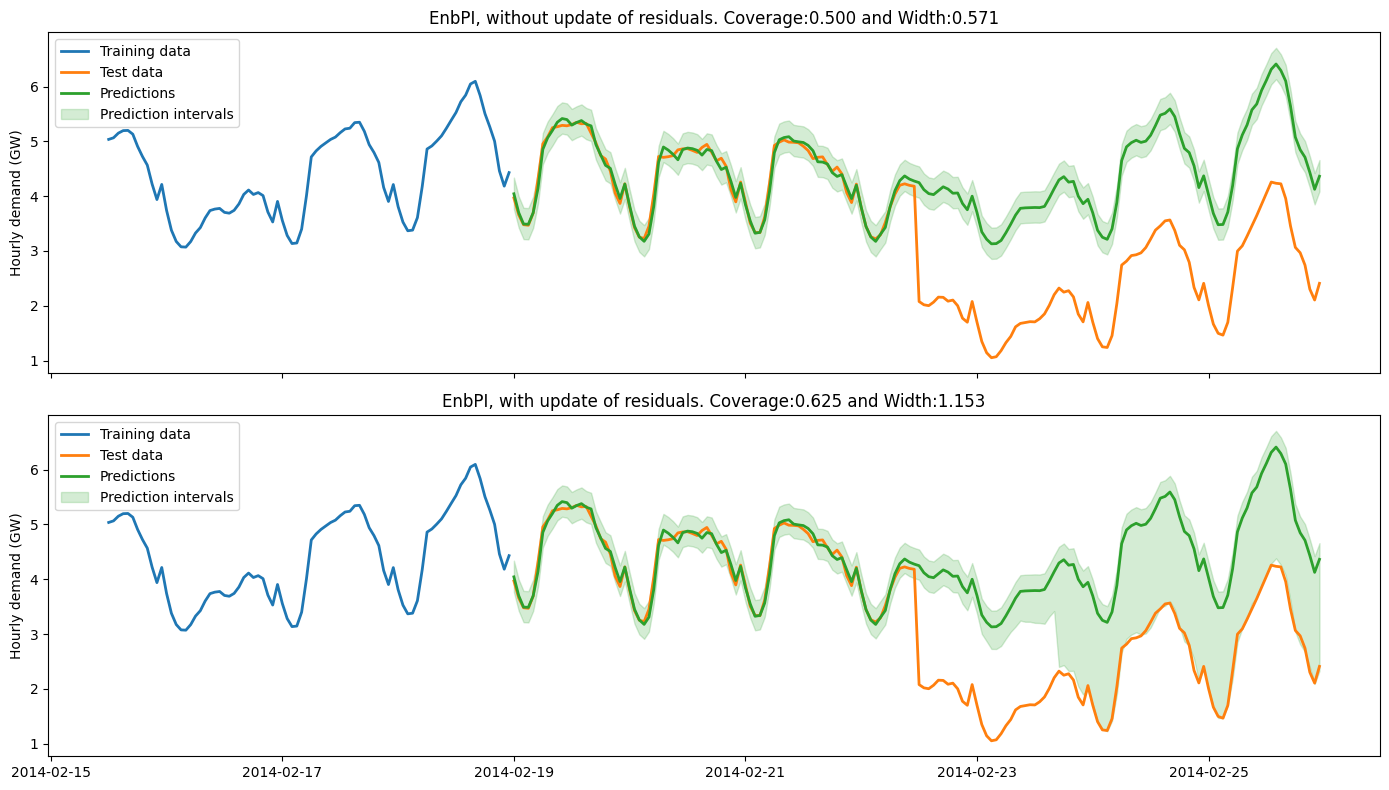

In [28]:
plot_forecast("EnbPI", y_train, y_test, y_enbpi_preds, y_enbpi_pis, coverages_enbpi, widths_enbpi, plot_coverage=True)

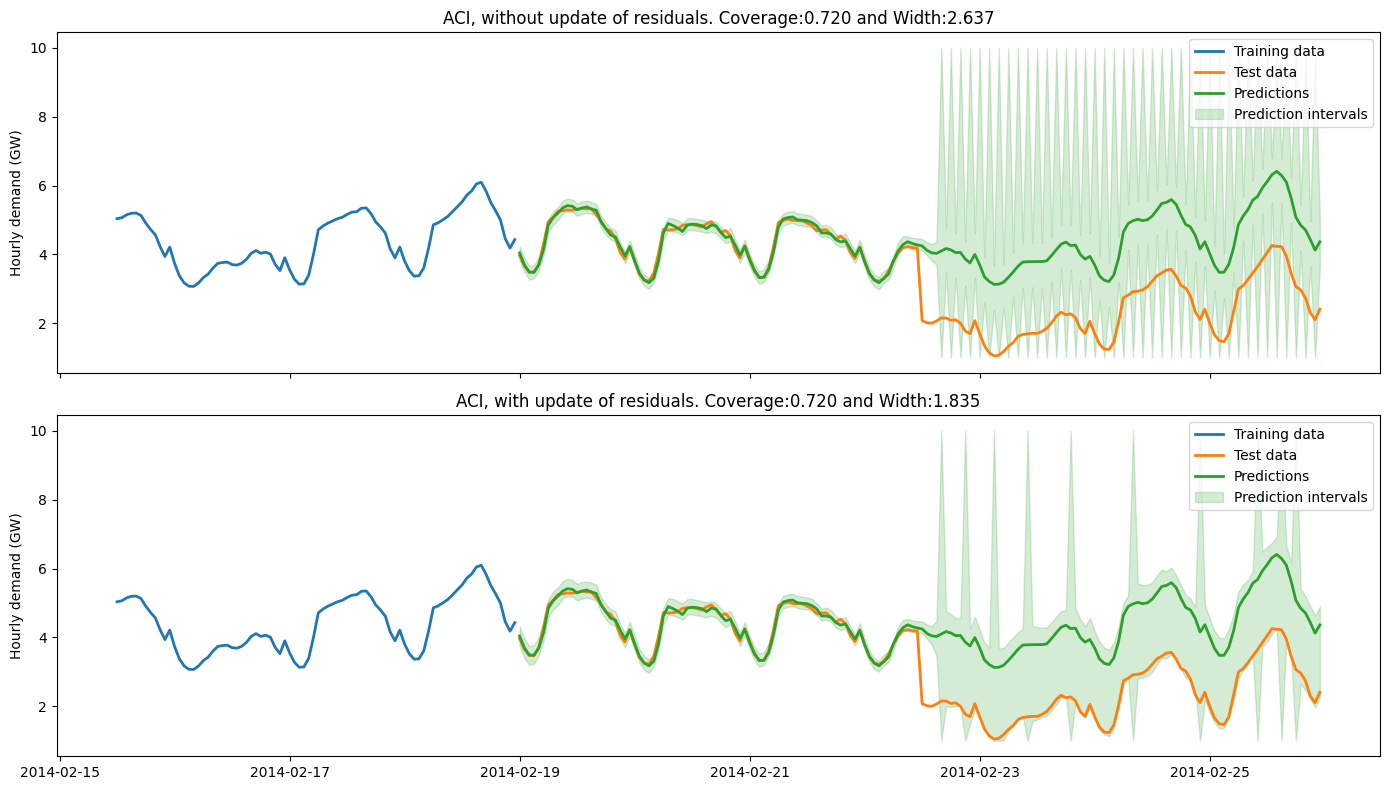

In [29]:
plot_forecast("ACI", y_train, y_test, y_aci_preds, y_aci_pis, coverages_aci, widths_aci, plot_coverage=True)


## Marginal coverage on a 24-hour rolling window of prediction intervals

Let's now compare the coverages obtained by MAPIE with and without update
of the residuals on a 24-hour rolling window of prediction intervals.

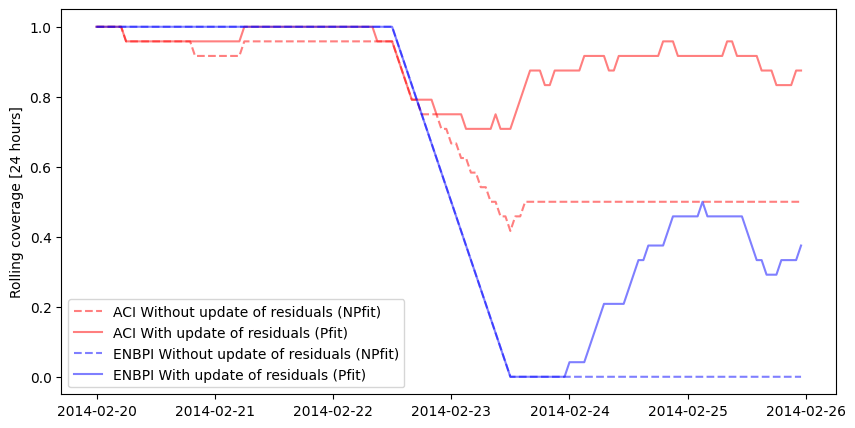

In [ ]:
rolling_coverage_aci_update, rolling_coverage_aci_no_update = [], []
rolling_coverage_enbpi_update, rolling_coverage_enbpi_no_update = [], []

window = 24

for i in range(window, len(y_test), 1):
    rolling_coverage_aci_no_update.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_aci_no_update[i-window:i, :, 0]
        )[0]
    )
    rolling_coverage_aci_update.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_aci_update[i-window:i, :, 0]
        )[0]
    )

    rolling_coverage_enbpi_no_update.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_enbpi_no_update[i-window:i, :, 0]
        )[0]
    )
    rolling_coverage_enbpi_update.append(
        regression_coverage_score(
            y_test[i-window:i], y_pis_enbpi_update[i-window:i, :, 0]
        )[0]
    )

plt.figure(figsize=(10, 5))
plt.ylabel(f"Rolling coverage [{window} hours]")

plt.plot(
    y_test[window:].index,
    rolling_coverage_aci_no_update,
    label="ACI Without update of residuals (no_update)",
    linestyle='--', color='r', alpha=0.5
)
plt.plot(
    y_test[window:].index,
    rolling_coverage_aci_update,
    label="ACI With update of residuals (update)",
    linestyle='-', color='r', alpha=0.5
)

plt.plot(
    y_test[window:].index,
    rolling_coverage_enbpi_no_update,
    label="ENBPI Without update of residuals (no_update)",
    linestyle='--', color='b', alpha=0.5
)
plt.plot(
    y_test[window:].index,
    rolling_coverage_enbpi_update,
    label="ENBPI With update of residuals (update)",
    linestyle='-', color='b', alpha=0.5
)

plt.legend()
plt.show()

## Temporal evolution of the distribution of residuals used for estimating prediction intervals


### ENBPI

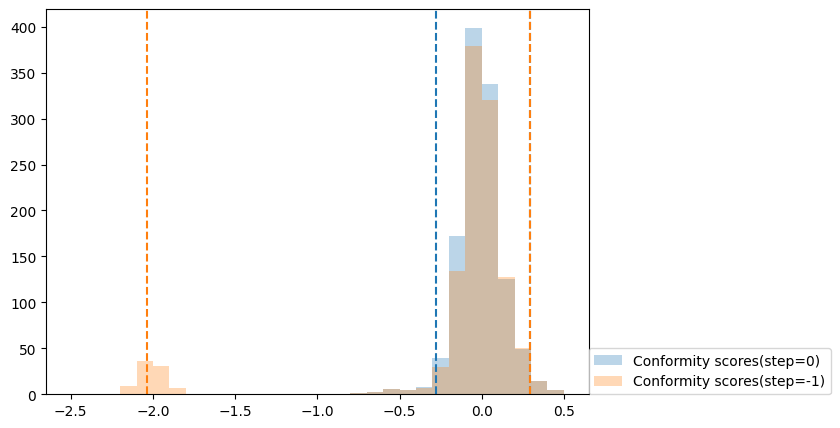

In [ ]:
plt.figure(figsize=(7, 5))
for i, j in enumerate([0, -1]):
    plt.hist(conformity_scores_enbpi_update[j], range=[-2.5, 0.5], bins=30, color=f"C{i}", alpha=0.3, label=f"Conformity scores(step={j})")
    plt.axvline(lower_quantiles_enbpi_update[j], ls="--", color=f"C{i}")
    plt.axvline(higher_quantiles_enbpi_update[j], ls="--", color=f"C{i}")
plt.legend(loc=[1, 0])

### ACI

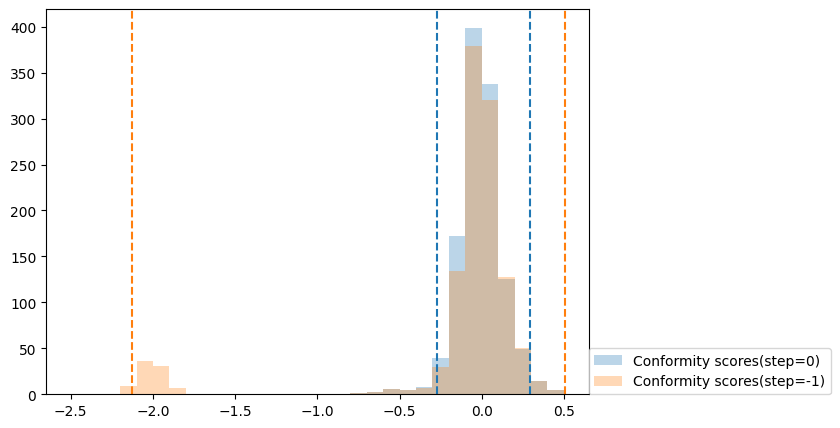

In [ ]:
plt.figure(figsize=(7, 5))
for i, j in enumerate([0, -1]):
    plt.hist(conformity_scores_aci_update[j], range=[-2.5, 0.5], bins=30, color=f"C{i}", alpha=0.3, label=f"Conformity scores(step={j})")
    plt.axvline(lower_quantiles_aci_update[j], ls="--", color=f"C{i}")
    plt.axvline(higher_quantiles_aci_update[j], ls="--", color=f"C{i}")
plt.legend(loc=[1, 0])

The training data do not contain a change point, hence the base model cannot
anticipate it.
Without update of the residuals, the prediction intervals are built upon the
distribution of the residuals of the training set.
Therefore they do not cover the true observations after the change point,
leading to a sudden decrease of the coverage.
However, the partial update of the residuals allows the method to capture the
increase of uncertainties of the model predictions.
One can notice that the uncertainty's explosion happens about one day late.
This is because enough new residuals are needed to change the quantiles
obtained from the residuals distribution.